In [18]:
import pandas as pd
from pytorch_tcn import TCN
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler

model = TCN(
    num_inputs = 2,
    num_channels=[16, 16],
    kernel_size = 3,
    # dilation_reset: Optional[ int ] = None,
    dropout = 0.2,
    causal = True,
    use_norm = 'weight_norm',
    activation = 'relu',
    kernel_initializer = 'xavier_uniform',
    use_skip_connections = False,
    # input_shape: str = 'NCL',
    # embedding_shapes: Optional[ ArrayLike ] = None,
    # embedding_mode: str = 'add',
    # use_gate: bool = False,
    output_projection = 1,
    output_activation = 'gelu',
)
df = pd.read_csv("dataset.csv")


In [19]:

pd.options.display.max_rows = 999
count_by_sec_and_mrc = df.groupby(["sector", "mrc"]).count().unstack().tavg.T.reset_index()

for i, row in count_by_sec_and_mrc.iterrows():
    mrc = row["mrc"]
    row = row.drop("mrc")
    if (row == 96).all():
        pass
    else:
        print(mrc)
        print((row == 96))


def remove_incomplete_mrc_sectors(df):
    unwanted_mrc_sectors = [
        ("Administration régionale Kativik", "AGRICOLE"),
        ("Administration régionale Kativik", "INDUSTRIEL"),
        ("Caniapiscau", "AGRICOLE"),
        ("Le Golfe-du-Saint-Laurent", "AGRICOLE")
    ]

    for mrc, sector in unwanted_mrc_sectors:
        df = df[~((df["mrc"] == mrc) & (df["sector"] == sector))]


    return df

df = remove_incomplete_mrc_sectors(df)
df["sector_mrc"] = df["sector"] + df["mrc"]
sector_mrcs = df["sector_mrc"].unique()


Administration régionale Kativik
sector
AGRICOLE          False
COMMERCIAL         True
INDUSTRIEL        False
INSTITUTIONNEL     True
RÉSIDENTIEL        True
Name: 3, dtype: bool
Caniapiscau
sector
AGRICOLE          False
COMMERCIAL         True
INDUSTRIEL         True
INSTITUTIONNEL     True
RÉSIDENTIEL        True
Name: 15, dtype: bool
Le Golfe-du-Saint-Laurent
sector
AGRICOLE          False
COMMERCIAL         True
INDUSTRIEL         True
INSTITUTIONNEL     True
RÉSIDENTIEL        True
Name: 45, dtype: bool


In [20]:


def preprocess(df):
    new_df = pd.DataFrame()
    for sector_mrc in sector_mrcs:
        sector_mrc_df = df[df["sector_mrc"] == sector_mrc].sort_index()
        sector_mrc_df["total_kwh"] = sector_mrc_df["total_kwh"].interpolate(method="index")

        new_df = pd.concat([new_df, sector_mrc_df])

    return new_df
df = preprocess(df)

df = df.set_index(pd.to_datetime(df.date, format="%Y-%m-%d")).sort_index()

kwh_scaler = StandardScaler()
temp_scaler = StandardScaler()
df[['total_kwh']] = kwh_scaler.fit_transform(df[['total_kwh']])
df[['tavg']] = temp_scaler.fit_transform(df[['tavg']])

train_df = df["2016":"2021"]
validation_df = df["2022":"2022"]
test_df = df["2023":]
df = df.drop(columns=["date"])
df = df.sort_values(["mrc", "sector", "date"])


# df = torch.tensor(df).float()


In [73]:
test_df[test_df["sector_mrc"] == "AGRICOLEDrummond"]

,mrc,sector,date,total_kwh,tavg,sector_mrc
date,,,,,,
2023-01-01,Drummond,AGRICOLE,2023-01-01,-0.214858,-0.987463,AGRICOLEDrummond
2023-02-01,Drummond,AGRICOLE,2023-02-01,-0.221431,-1.208057,AGRICOLEDrummond
2023-03-01,Drummond,AGRICOLE,2023-03-01,-0.218999,-0.427491,AGRICOLEDrummond
2023-04-01,Drummond,AGRICOLE,2023-04-01,-0.237308,0.140965,AGRICOLEDrummond
2023-05-01,Drummond,AGRICOLE,2023-05-01,-0.239468,0.616092,AGRICOLEDrummond
2023-06-01,Drummond,AGRICOLE,2023-06-01,-0.238293,1.167580,AGRICOLEDrummond
2023-07-01,Drummond,AGRICOLE,2023-07-01,-0.221860,1.388174,AGRICOLEDrummond
2023-08-01,Drummond,AGRICOLE,2023-08-01,-0.227389,1.091220,AGRICOLEDrummond
2023-09-01,Drummond,AGRICOLE,2023-09-01,-0.232928,0.997891,AGRICOLEDrummond


In [10]:
def get_sequence(df: pd.DataFrame, sector_mrc: str):
    """Get a sequence of total_kwh and tavg for a given sector_mrc"""

    # print(mrc)
    sequence = df[df.sector_mrc == sector_mrc]
    sequence = sequence[["total_kwh", "tavg"]]

    starting_level = sequence["total_kwh"].iloc[0]
    # sequence["total_kwh"] = sequence["total_kwh"].diff()

    # Label is the next total_kwh
    sequence["label"] = sequence.total_kwh.shift(-1)
    # Drop the last row
    sequence = sequence.dropna()

    dates = sequence.index
    sequence = sequence[['total_kwh', 'tavg', 'label']]
    sequence = torch.tensor(sequence.values).float()

    # print(sequence.shape)

    return sequence, dates, starting_level

def get_n_sequences(sector_mrc: list[str], subset="train"):
    """Get a tensor of sequences for a list of sector_mrcs"""
    if subset == "train":
        df = train_df
    elif subset == "validation":
        df = pd.concat((train_df[train_df.date >= "2021-07-01"], validation_df), axis=0)
    elif subset == "test":
        df = pd.concat((validation_df[validation_df.date >= "2022-07-01"], test_df), axis=0)

    result = []
    starting_levels = []
    for sector_mrc in sector_mrc:
        sequence, dates, starting_level = get_sequence(df, sector_mrc)
        result.append(sequence)
        starting_levels.append(starting_level)
    stacked = torch.stack(result)
    starting_levels = torch.tensor(starting_levels).float().unsqueeze(1)
    return stacked, dates, starting_levels


# def get_windowed_sequence(sequence, window_size=10):
#     '''
#     Args:
#         - Sequence: first dimension is the batch size, second dimension is the sequence length, third dimension is the number of features
#     Returns:
#         - Windowed sequence: first dimension is the batch size, second dimension is the sequence length, third dimension is the number of features * window_size
#     '''
#     batch_size, sequence_length, num_features = sequence.shape
#     windowed_sequence = torch.zeros((batch_size, sequence_length, num_features * (1 + window_size)))
#     windowed_sequence[:, :, :num_features] = sequence
#     for i in range(1, window_size + 1):
#         windowed_sequence[:, i:, num_features * i:num_features * (i + 1)] = sequence[:, :-i, :]

#     # Drop rows for which the window is incomplete
#     windowed_sequence = windowed_sequence[:, window_size:, :]

#     # print(windowed_sequence.shape)

#     return windowed_sequence


In [92]:
EPOCHS = 10
BATCH_SIZE = 32



optim = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()
losses = []
for epoch in range(EPOCHS):
    for i in range(0, len(sector_mrcs), BATCH_SIZE):
        sector_mrc = sector_mrcs[i:i + BATCH_SIZE]

        batch, dates, starting_levels = get_n_sequences(sector_mrc, subset="train")

        batch = batch.permute(0, 2, 1)
        X = batch[:, :-1, :]
        y = batch[:, -1, :]
        
        # y = torch.cat((starting_levels, y), dim=1)

        optim.zero_grad()
        model.reset_buffers()
        output = model(X)
        loss = criterion(output.squeeze(), y)
        loss.backward()
        optim.step()
        print(f"Epoch {epoch} Batch {i} Loss {loss.item()}")


        losses.append(loss.item())
    print(f"Epoch {epoch} Loss {pd.Series(losses).mean()}")
    losses = []

Epoch 0 Batch 0 Loss 0.3196171820163727
Epoch 0 Batch 32 Loss 0.07704698294401169
Epoch 0 Batch 64 Loss 0.1706409752368927
Epoch 0 Batch 96 Loss 0.5546565055847168
Epoch 0 Batch 128 Loss 0.5345579981803894
Epoch 0 Batch 160 Loss 0.16261915862560272
Epoch 0 Batch 192 Loss 0.9246392250061035
Epoch 0 Batch 224 Loss 0.08422736078500748
Epoch 0 Batch 256 Loss 0.04581036418676376
Epoch 0 Batch 288 Loss 3.1349387168884277
Epoch 0 Batch 320 Loss 0.04168412834405899
Epoch 0 Batch 352 Loss 0.06847657263278961
Epoch 0 Batch 384 Loss 0.10946015268564224
Epoch 0 Batch 416 Loss 0.07814500480890274
Epoch 0 Loss 0.4504657377089773
Epoch 1 Batch 0 Loss 0.20270776748657227
Epoch 1 Batch 32 Loss 0.07814957946538925
Epoch 1 Batch 64 Loss 0.10705002397298813
Epoch 1 Batch 96 Loss 0.29023686051368713
Epoch 1 Batch 128 Loss 0.3500467836856842
Epoch 1 Batch 160 Loss 0.14701838791370392
Epoch 1 Batch 192 Loss 1.7304582595825195
Epoch 1 Batch 224 Loss 0.04803517460823059
Epoch 1 Batch 256 Loss 0.028828067705035

In [ ]:
# Test 
global_results = pd.DataFrame()
with torch.no_grad():
    for mrc in ["Drummond", "Les Etchemins"]:
        for sector in df["sector"].unique():

            sector_mrc = sector + mrc
            batch, dates, starting_levels = get_n_sequences([sector_mrc], subset="test")
            batch = batch.permute(0, 2, 1)
            X = batch[:, :-1, :]
            y = batch[:, -1, :]
            model.reset_buffers()
            output = model(X)
            # print(dates)
            # print(output.shape)
            # print(y.shape)
            # Only keep entries for test set
            output = output[:, :, 5:]
            # print(y.shape)
            y = y[:, 5:]

            y = kwh_scaler.inverse_transform(y)
            output = kwh_scaler.inverse_transform(output.squeeze(0))

            results = pd.DataFrame({"sector_mrc": sector_mrc, "date": dates[5:], "label": y.squeeze(), "output": output.squeeze()})
            global_results = pd.concat([global_results, results])

global_results.to_csv("tcn_preds.csv", index=False)

In [93]:
test_df[test_df["sector_mrc"] == "AGRICOLEDrummond"]

kwh_scaler.inverse_transform(test_df[test_df["sector_mrc"] == "AGRICOLEDrummond"][["total_kwh"]])

array([[6846496.],
       [6473865.],
       [6611757.],
       [5573804.],
       [5451344.],
       [5517997.],
       [6449576.],
       [6136128.],
       [5822133.],
       [6246672.],
       [7069067.],
       [6910862.]])

In [11]:
state_dict = torch.load('tcn.pth')

model = TCN(
    num_inputs = 2,
    num_channels=[8, 16],
    kernel_size = 3,
    # dilation_reset: Optional[ int ] = None,
    dropout = 0.2,
    causal = True,
    use_norm = 'weight_norm',
    activation = 'relu',
    kernel_initializer = 'xavier_uniform',
    use_skip_connections = True,
    # input_shape: str = 'NCL',
    # embedding_shapes: Optional[ ArrayLike ] = None,
    # embedding_mode: str = 'add',
    # use_gate: bool = False,
    output_projection = 1,
    output_activation = 'gelu',
)

model.load_state_dict(state_dict)

/var/folders/xn/3599xwv92dv0b2nzybpwbzlr0000gn/T/ipykernel_59024/3450802968.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('tcn.pth')


<All keys matched successfully>

In [42]:
# Compute performance on test set
with torch.no_grad():
    measures = pd.DataFrame()
    for sector in test_df["sector"].unique():
        for mrc in test_df["mrc"].unique():
            sector_mrc = sector + mrc
            try:
                batch, dates, starting_levels = get_n_sequences([sector_mrc], subset="test")
            except:
                continue
            batch = batch.permute(0, 2, 1)
            X = batch[:, :-1, :]
            y = batch[:, -1, :]
            model.reset_buffers()
            output = model(X)
            output = output[:, :, 5:]
            y = y[:, 5:]

            y = kwh_scaler.inverse_transform(y)
            output = kwh_scaler.inverse_transform(output.squeeze(0))

            results = pd.DataFrame({"sector_mrc": sector_mrc, "sector": sector, "mrc":mrc, "date": dates[5:], "label": y.squeeze(), "output": output.squeeze()})
            results["error"] = results["label"] - results["output"]
            results["rmse"] = (results["error"] ** 2).mean() ** 0.5
            results["abs_error"] = results["error"].abs()
            results["abs_error_pct"] = results["abs_error"] / results["label"]

            measures = pd.concat([measures, results])

        # rmse = (results["error"] ** 2).mean() ** 0.5
        # mae = results["abs_error"].mean()
        # mape = results["abs_error_pct"].mean()


In [41]:
measures.groupby("sector")["abs_error_pct"].mean()

sector
AGRICOLE          101.696619
COMMERCIAL          3.742485
INDUSTRIEL         55.519660
INSTITUTIONNEL     14.029850
RÉSIDENTIEL         1.162866
Name: abs_error_pct, dtype: float64

In [43]:
measures.groupby("sector")["rmse"].mean()

sector
AGRICOLE          2.366426e+07
COMMERCIAL        1.713881e+07
INDUSTRIEL        4.769283e+07
INSTITUTIONNEL    2.197250e+07
RÉSIDENTIEL       2.509758e+07
Name: rmse, dtype: float64

In [49]:
2.509758e+07

25097580.0

In [ ]:
results.groupby("sector")

,sector_mrc,date,label,output,error,abs_error,abs_error_pct
0,INDUSTRIELAbitibi,2022-12-01,2.022872e+07,1.044755e+07,9.781172e+06,9.781172e+06,0.483529
1,INDUSTRIELAbitibi,2023-01-01,1.984752e+07,1.198555e+07,7.861975e+06,7.861975e+06,0.396119
2,INDUSTRIELAbitibi,2023-02-01,2.107242e+07,1.339317e+07,7.679253e+06,7.679253e+06,0.364422
3,INDUSTRIELAbitibi,2023-03-01,1.917062e+07,1.459829e+07,4.572327e+06,4.572327e+06,0.238507
4,INDUSTRIELAbitibi,2023-04-01,1.995176e+07,1.016573e+07,9.786031e+06,9.786031e+06,0.490485
5,INDUSTRIELAbitibi,2023-05-01,1.684088e+07,9.877751e+06,6.963130e+06,6.963130e+06,0.413466
6,INDUSTRIELAbitibi,2023-06-01,1.685210e+07,1.300392e+07,3.848183e+06,3.848183e+06,0.228350
7,INDUSTRIELAbitibi,2023-07-01,1.864852e+07,2.194760e+07,-3.299075e+06,3.299075e+06,0.176908
8,INDUSTRIELAbitibi,2023-08-01,1.848425e+07,3.081774e+07,-1.233350e+07,1.233350e+07,0.667244
9,INDUSTRIELAbitibi,2023-09-01,1.970117e+07,5.252504e+07,-3.282387e+07,3.282387e+07,1.666087


In [61]:
rmse = (measures["error"] ** 2).mean() ** 0.5
mae = measures["abs_error"].mean()
mape = measures["abs_error_pct"].mean()

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")


RMSE: 4440469.981325566
MAE: 1607579.401036528
MAPE: -0.008721401567399383


In [48]:
mape

np.float64(-7.915351241600473e-05)

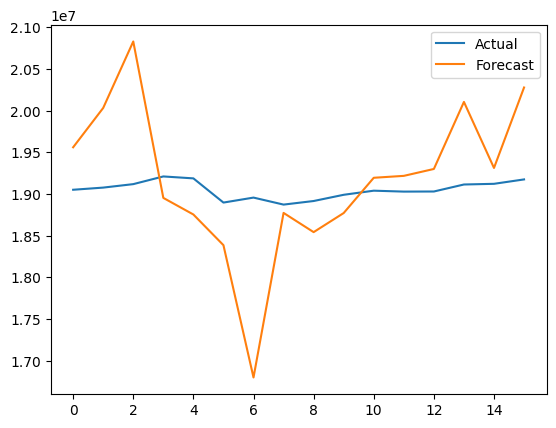

MAPE for AGRICOLEAbitibi is 0.03317013828331798


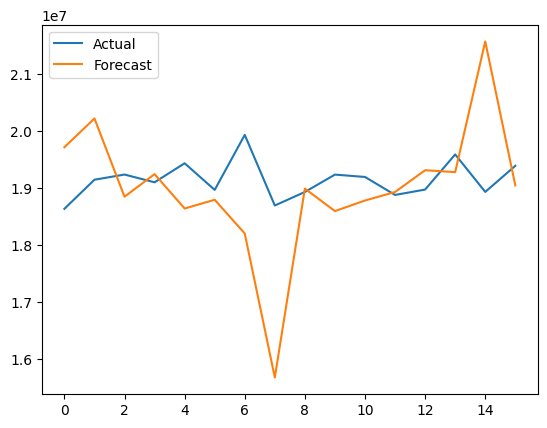

MAPE for INDUSTRIELMatawinie is 0.04313109394163612


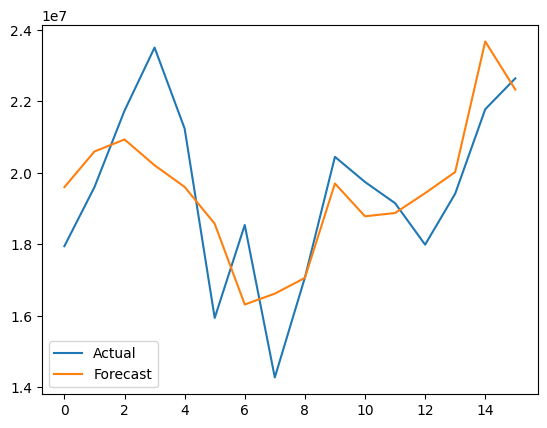

MAPE for COMMERCIALMatawinie is 0.07245426503733013


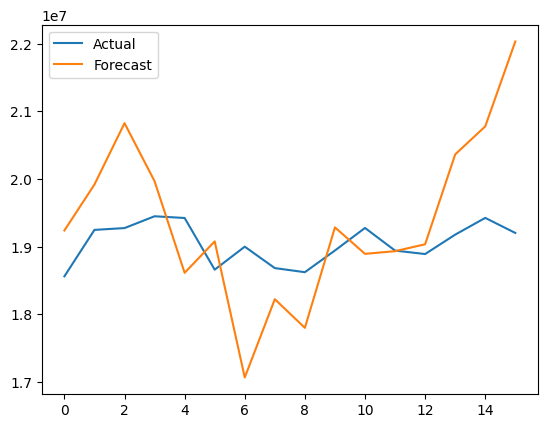

MAPE for AGRICOLEMatawinie is 0.04617036135844636


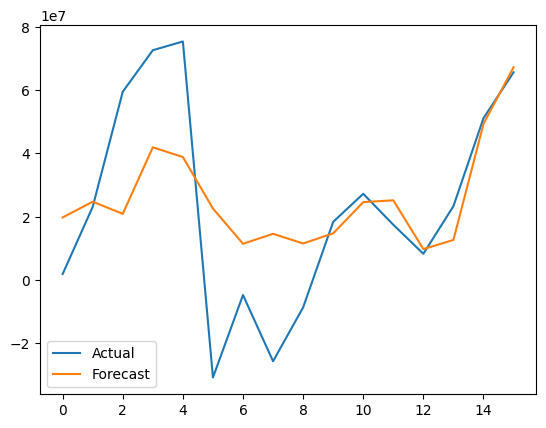

MAPE for RÉSIDENTIELLes Moulins is 1.3795275612195599


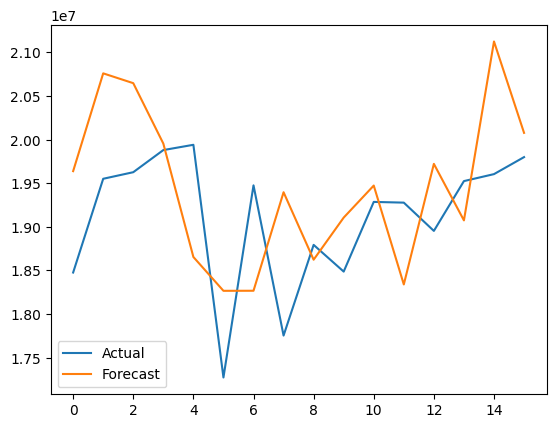

MAPE for INSTITUTIONNELLes Moulins is 0.04458307675663435


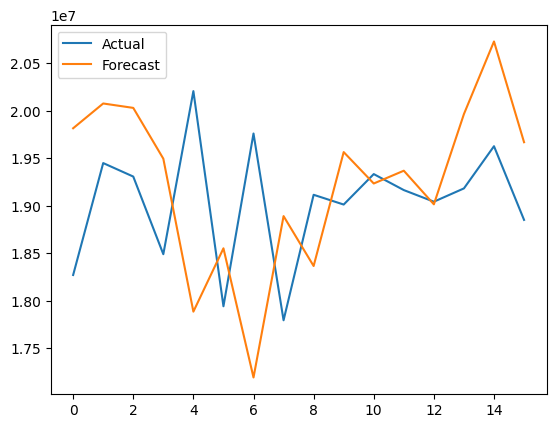

MAPE for INDUSTRIELLes Moulins is 0.048403912651874756


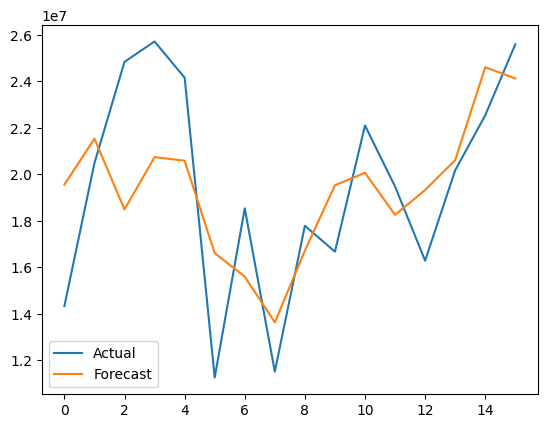

MAPE for COMMERCIALLes Moulins is 0.16118113066173437


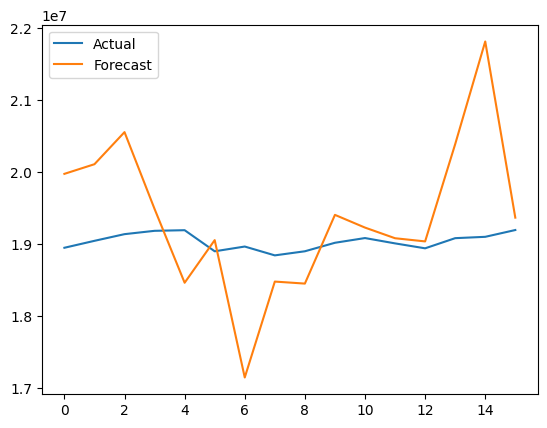

MAPE for AGRICOLELes Moulins is 0.04003077628462355


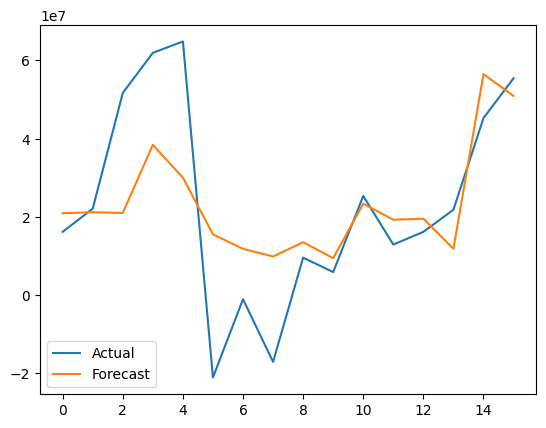

MAPE for RÉSIDENTIELL'Assomption is 1.2377851509175404


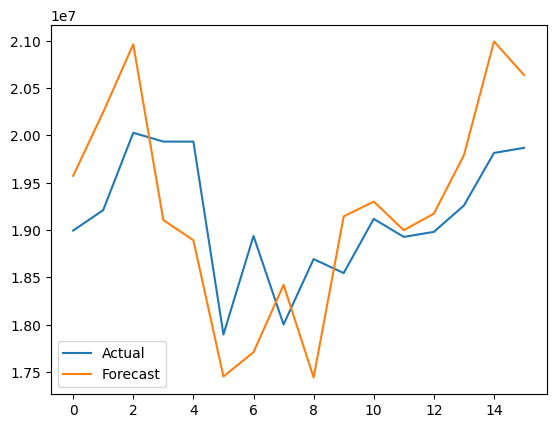

MAPE for INSTITUTIONNELL'Assomption is 0.03661003114772439


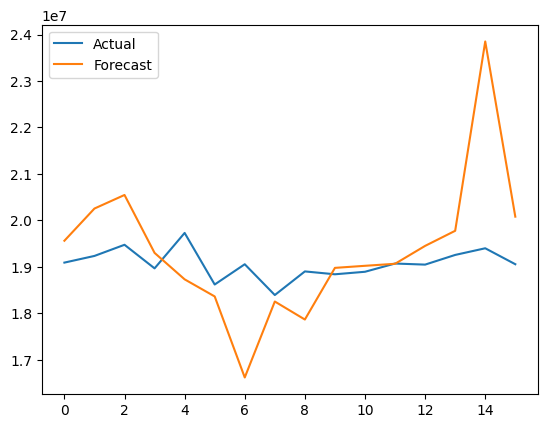

MAPE for INDUSTRIELL'Assomption is 0.046908969897342105


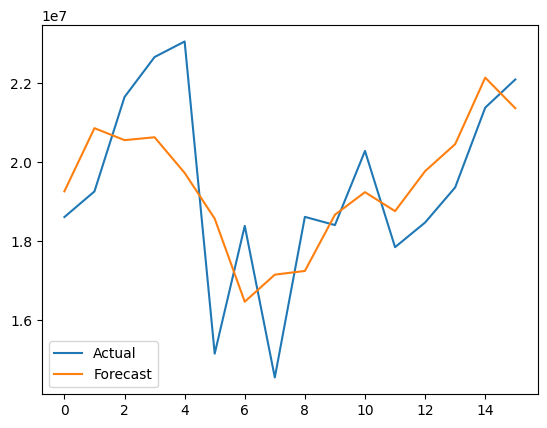

MAPE for COMMERCIALL'Assomption is 0.08116861769818028


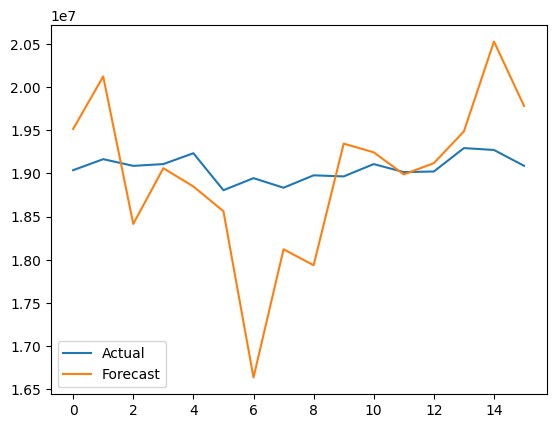

MAPE for AGRICOLEL'Assomption is 0.03155798947772333


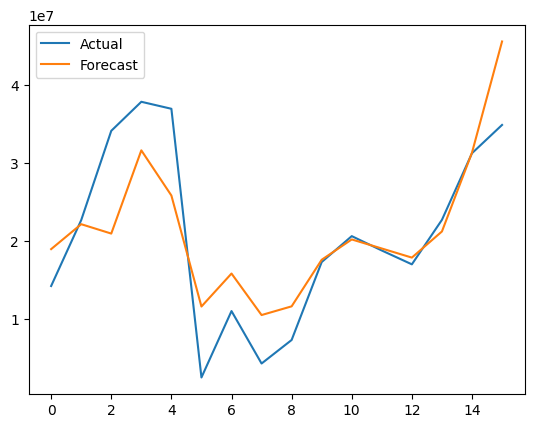

MAPE for RÉSIDENTIELJoliette is 0.4969404619350511


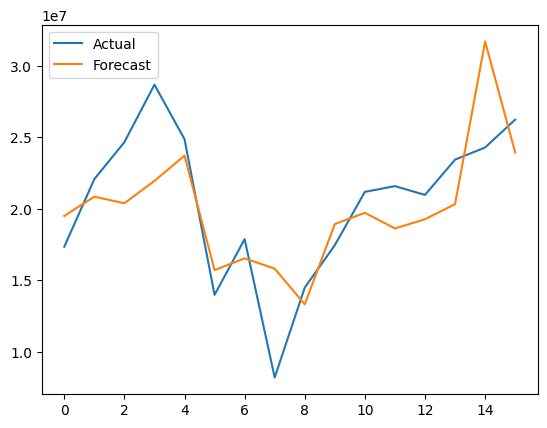

MAPE for INSTITUTIONNELJoliette is 0.17107628718650802


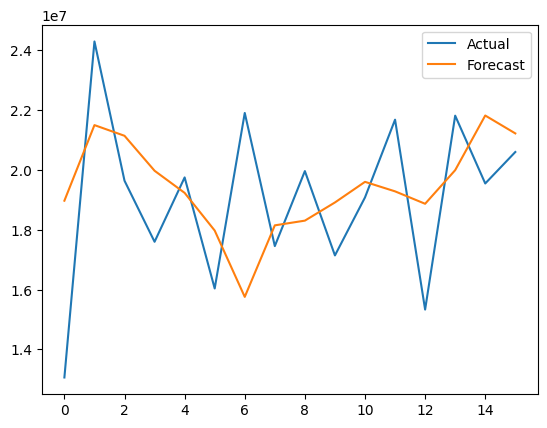

MAPE for INDUSTRIELJoliette is 0.12668578719694185


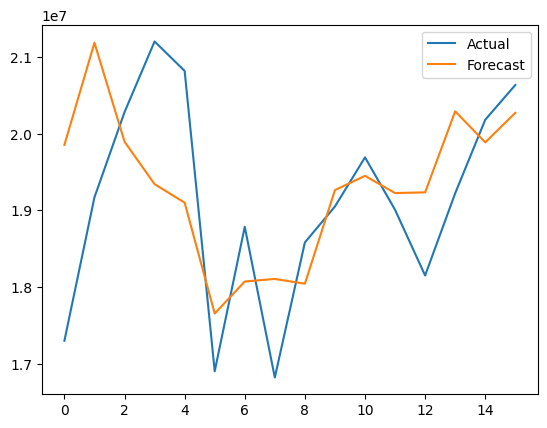

MAPE for COMMERCIALJoliette is 0.050783124590377746


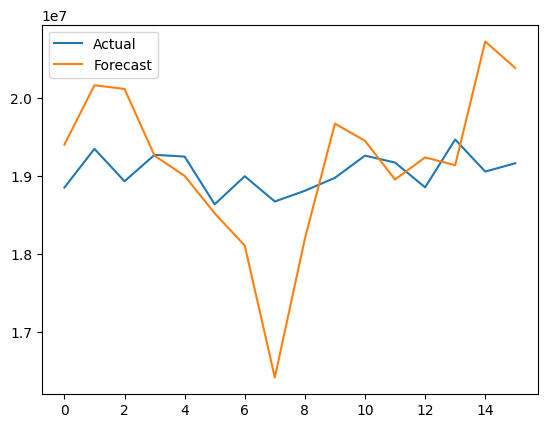

MAPE for AGRICOLEJoliette is 0.037456546504923596


KeyboardInterrupt: 

In [ ]:
def validate():
    mapes = []
    with torch.no_grad():
        for sector_mrc in sector_mrcs:
            batch, dates, starting_levels = get_n_sequences([sector_mrc], subset="validation")
            batch = batch.permute(0, 2, 1)
            X = batch[:, :-1, :]
            y = batch[:, -1, :]
            model.reset_buffers()
            output = model(X)
            y = kwh_scaler.inverse_transform(y)
            output = kwh_scaler.inverse_transform(output.squeeze(1))
            plt.plot(y.squeeze())
            plt.plot(output.squeeze())
            plt.legend(["Actual", "Forecast"])
            plt.show()
            mape = (abs(y - output) / abs(y)).mean()
            print(f"MAPE for {sector_mrc} is {mape}")
            mapes.append(mape)

    return mapes

mapes = validate()

In [122]:
import numpy as np
np.mean(mapes)

np.float64(0.2688944419543672)